In [1]:
# Cell 001
import pandas as pd
pd.options.mode.chained_assignment = None  # Désactive l'avertissement SettingWithCopyWarning
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('data/clean.csv')

In [2]:
# Cell 002
# Nous avons notre dataset principal. Créons maintenant 3 autres datasets plus petits.
# Pour cela, nous allons nous servir de la colonne 'days_since_last_order'.
# Tout d'abord, trier le dataset par 'days_since_last_order'.

df = df.sort_values(by='days_since_last_order')

In [3]:
# Cell 003
# Créons maintenant 3 datasets dégradés.
# Le premier dataset correspond aux données de df -15% du nombre de lignes, selon l'ordre défini.
# Le deuxième dataset correspond aux données de df -30% du nombre de lignes, selon l'ordre défini.
# Le troisième dataset correspond aux données de df -50% du nombre de lignes, selon l'ordre défini.

# Calcul du nombre de lignes pour chaque dataset dégradé
n_rows = len(df)
n_rows_85 = int(n_rows * 0.85)  # -15%
n_rows_70 = int(n_rows * 0.70)  # -30%
n_rows_50 = int(n_rows * 0.50)  # -50%

# Création des datasets dégradés
df_85 = df.head(n_rows_85)
df_70 = df.head(n_rows_70)
df_50 = df.head(n_rows_50)

# Affichage des tailles des datasets pour vérification
print(f"Taille du dataset original : {len(df)}")
print(f"Taille du dataset -15% : {len(df_85)}")
print(f"Taille du dataset -30% : {len(df_70)}")
print(f"Taille du dataset -50% : {len(df_50)}")

Taille du dataset original : 72313
Taille du dataset -15% : 61466
Taille du dataset -30% : 50619
Taille du dataset -50% : 36156


In [4]:
# Cell 004
# Calcul des décalages en jours depuis df50
max_days_50 = df_50['days_since_last_order'].max()
max_days_70 = df_70['days_since_last_order'].max()
max_days_85 = df_85['days_since_last_order'].max()
max_days_original = df['days_since_last_order'].max()

# Calcul des décalages
df_50_decalage_days = 0  # Point de départ
df_70_decalage_days = int(max_days_70 - max_days_50)
df_85_decalage_days = int(max_days_85 - max_days_50)
df_decalage_days = int(max_days_original - max_days_50)

# Affichage des résultats
print(f"Décalage pour df_50 : {df_50_decalage_days} jours")
print(f"Décalage pour df_70 : {df_70_decalage_days} jours")
print(f"Décalage pour df_85 : {df_85_decalage_days} jours")
print(f"Décalage pour df : {df_decalage_days} jours")

Décalage pour df_50 : 0 jours
Décalage pour df_70 : 96 jours
Décalage pour df_85 : 197 jours
Décalage pour df : 462 jours


In [7]:
# Cell 005
from sklearn.preprocessing import StandardScaler

# Fonction pour normaliser les colonnes d'un DataFrame
def normalize_dataframe(df, columns_to_normalize):
    normalized_df = df.copy()
    scaler = StandardScaler()
    
    for col in columns_to_normalize:
        normalized_df.loc[:, f'{col}_normalized'] = scaler.fit_transform(normalized_df[[col]])
    
    return normalized_df

# Définir les colonnes à normaliser
columns_to_normalize = [
    'avg_delivery_time_days',
    'days_since_last_order',
    'avg_review_score',
    'max_delivery_delay_days',
    'has_comment',
    'last_payment_installments'
]

# Normaliser chaque DataFrame
df = normalize_dataframe(df, columns_to_normalize)
df_85 = normalize_dataframe(df_85, columns_to_normalize)
df_70 = normalize_dataframe(df_70, columns_to_normalize)
df_50 = normalize_dataframe(df_50, columns_to_normalize)

print("Normalisation effectuée pour tous les DataFrames.")

Normalisation effectuée pour tous les DataFrames.


In [12]:
# Cell 006
features = [
    'avg_delivery_time_days_normalized', 
    'days_since_last_order_normalized', 
    'avg_review_score_normalized', 
    'max_delivery_delay_days_normalized', 
    'has_comment_normalized', 
    'last_payment_installments_normalized'
]

In [13]:
# Cell 007
# Préparation des données pour le clustering
def prepare_data(df):
    X = df[features]
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Préparation des données pour df_50
X_50_scaled = prepare_data(df_50)

# Création et entraînement du modèle KMeans sur df_50
kmeans_model = KMeans(n_clusters=6, random_state=42)
kmeans_model.fit(X_50_scaled)

print("Modèle KMeans entraîné sur df_50.")

Modèle KMeans entraîné sur df_50.


c:\Users\jeanc\.conda\envs\oc-p4\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jeanc\.conda\envs\oc-p4\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\jeanc\.conda\envs\oc-p4\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanc\.conda\envs\oc-p4\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\jeanc\.conda\envs\oc-p4\Lib\subprocess.py", line 1538, in _execute_child


In [14]:
# Cell 008
# Application du modèle KMeans à tous les dataframes
df_copy = df.copy()
df_85_copy = df_85.copy()
df_70_copy = df_70.copy()
df_50_copy = df_50.copy()

df_copy['cluster'] = kmeans_model.predict(prepare_data(df))
df_85_copy['cluster'] = kmeans_model.predict(prepare_data(df_85))
df_70_copy['cluster'] = kmeans_model.predict(prepare_data(df_70))
df_50_copy['cluster'] = kmeans_model.predict(X_50_scaled)  # Utiliser les données déjà préparées

# Calcul des scores ARI
ari_50 = 1.0  # Le score ARI de df_50 par rapport à lui-même est toujours 1
ari_70 = adjusted_rand_score(df_50_copy['cluster'], df_70_copy['cluster'].iloc[:len(df_50)])
ari_85 = adjusted_rand_score(df_50_copy['cluster'], df_85_copy['cluster'].iloc[:len(df_50)])
ari_100 = adjusted_rand_score(df_50_copy['cluster'], df_copy['cluster'].iloc[:len(df_50)])

# Création de la matrice de décalage
decalage_matrix = pd.DataFrame({
    'Dataset': ['df_50', 'df_70', 'df_85', 'df'],
    'Décalage (jours)': [df_50_decalage_days, df_70_decalage_days, df_85_decalage_days, df_decalage_days],
    'ARI Score': [ari_50, ari_70, ari_85, ari_100]
})

print("Matrice de décalage et scores ARI:")
print(decalage_matrix)

Matrice de décalage et scores ARI:
  Dataset  Décalage (jours)  ARI Score
0   df_50                 0   1.000000
1   df_70                96   0.749181
2   df_85               197   0.671890
3      df               462   0.636865


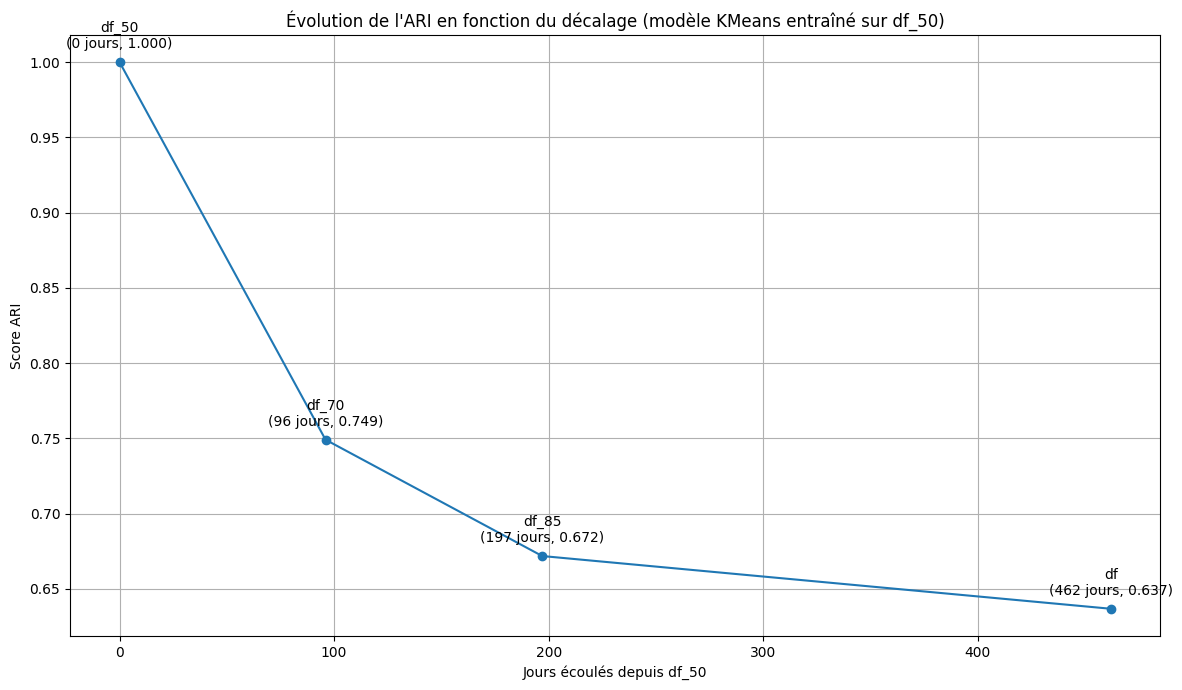

In [15]:
# Cell 009
# Création de la courbe d'évolution de l'ARI
plt.figure(figsize=(12, 7))
plt.plot(decalage_matrix['Décalage (jours)'], decalage_matrix['ARI Score'], marker='o')
plt.title("Évolution de l'ARI en fonction du décalage (modèle KMeans entraîné sur df_50)")
plt.xlabel("Jours écoulés depuis df_50")
plt.ylabel("Score ARI")
plt.grid(True)

# Ajout des annotations pour chaque point
for i, row in decalage_matrix.iterrows():
    plt.annotate(f"{row['Dataset']}\n({row['Décalage (jours)']} jours, {row['ARI Score']:.3f})",
                 (row['Décalage (jours)'], row['ARI Score']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.tight_layout()
plt.show()